'''
Author:
        
        PARK, JunHo, junho@ccnets.org

        
        KIM, JoengYoong, jeongyoong@ccnets.org
        
    COPYRIGHT (c) 2024. CCNets. All Rights reserved.
'''

In [1]:
import sys

path_append = "../../" # Go up one directory from where you are.
sys.path.append(path_append) 

from tools.config.ml_config import MLConfig
from tools.config.data_config import DataConfig
from nn.utils.init_layer import set_random_seed
set_random_seed(0)

In [2]:
import torch
import torchvision.datasets as dset
from torchvision import transforms
# import albumentations
n_img_sz = 128
attribute_indices = torch.tensor([20, 31, 39, 21]) # Male, Smiling, Young, Eyeglasses

# Load the CelebA dataset for training. Specify the root directory where the dataset is located
trainset = dset.CelebA(root=path_append + '../data/celeba', split = "train", transform=transforms.Compose([
                            transforms.Resize(n_img_sz), # Transformations include resizing the images to `n_img_sz`
                            transforms.CenterCrop(n_img_sz), # Center cropping to the same size
                            transforms.ToTensor(), # Converting the images to tensors,
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalizing the pixel values to have a mean and standard deviation of 0.5 across all channels.
                        ]), download= False)

testset = dset.CelebA(root=path_append + '../data/celeba', split = "test", transform=transforms.Compose([
                            transforms.Resize(n_img_sz), # Transformations include resizing the images to `n_img_sz`
                            transforms.CenterCrop(n_img_sz), # Center cropping to the same size
                            transforms.ToTensor(), # Converting the images to tensors
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalizing the pixel values to have a mean and standard deviation of 0.5 across all channels.
                        ]), download= False)    


In [3]:
# Custom dataset class for CelebA dataset
class CelebA(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    
    def __getitem__(self, index):
        X, y = self.dataset[index] # Get the image and label at the specified index
        y= torch.index_select(y.unsqueeze(0), 1, attribute_indices).squeeze(0) # Select specific attributes(Male, Smiling) for the label using a predefined list of indices
        return X, y # Return the image and the selected attri   butes
    
    def __len__(self):
        return len(self.dataset) # Return the size of the dataset
        
trainset = CelebA(trainset)
testset = CelebA(testset)

In [4]:

data_config = DataConfig(dataset_name = 'celebA', task_type='multi_label_classification', obs_shape=[3, 128, 128], label_size=len(attribute_indices), \
                        show_image_indices=[737, 1518, 390, 607])

#  Set training configuration from the AlgorithmConfig class, returning them as a Namespace object.
ml_config = MLConfig(model_name = 'resnet18')
ml_config.training.error_function = 'mae'
ml_config.optimization.learning_rate = 2e-4

first_data = trainset[0]
X, y = first_data

print(f"Input shape: {X.shape}")
print(f"Label shape: {y.shape}")

print(f"Total number of samples in trainset: {len(trainset)}")

Input shape: torch.Size([3, 128, 128])
Label shape: torch.Size([4])
Total number of samples in trainset: 162770


In [5]:
from causal_learning import CausalLearning

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# Initialize the CausalLearning class with the training configuration, data configuration, device, and use_print and use_wandb flags
causal_learning = CausalLearning(ml_config, data_config, device, use_print=True, use_wandb=False)

c:\Users\ccnets-team\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ccnets-team\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Trainer Name: causal_trainer


ModelConfig Parameters:


,d_model,dropout,model_name,num_layers,use_seq_input
0,256,0.05,resnet18,5,False


TrainConfig Parameters:


,batch_size,error_function,max_seq_len,min_seq_len,num_epoch
0,64,mae,None,None,100


OptimConfig Parameters:


,clip_grad_range,decay_rate_100k,learning_rate,max_grad_norm,scheduler_type
0,None,0.05,0.0002,1.0,exponential


DataConfig Parameters:


,dataset_name,task_type,obs_shape,label_size,explain_size,show_image_indices
0,celeba,multi_label_classification,"[3, 128, 128]",4,None,"[737, 1518, 390, 607]"



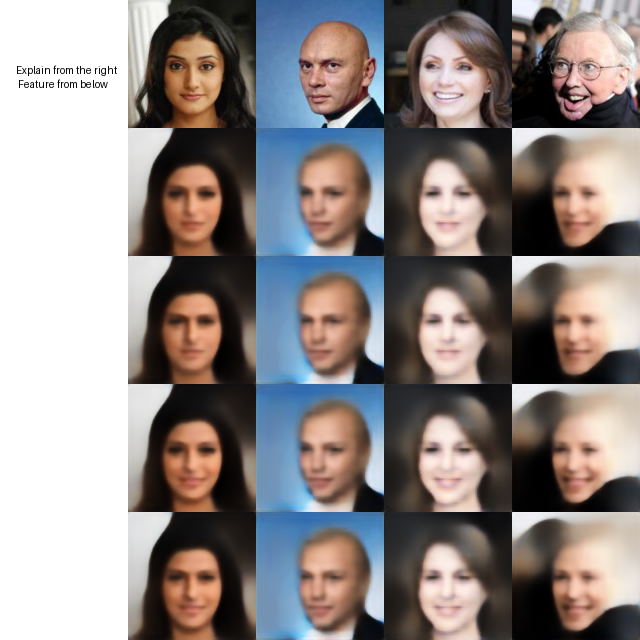

[6/100][1642/2543][Time 25.87]
Unified LR across all optimizers: 0.00012054325546051825
=====================Train Metrics=======================
CCNet:  Three Resnet18
Inf: 0.0054	Gen: 0.1361	Rec: 0.1360	E: 0.0055	R: 0.0053	P: 0.2667

accuracy: 0.9336

=====================Eval Metrics========================
accuracy: 0.9160



In [6]:
causal_learning.train(trainset, testset)    